In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
# ========================================
# 경로 설정 (여기를 수정하세요)
# ========================================
DATA_DIR = '/content/drive/MyDrive/Colab Notebooks/machine-learning-practice/Machine-Learning-Programming/week7/data/cifar10_data'  # CIFAR-10 데이터를 저장할 경로

# 데이터 디렉토리 생성
os.makedirs(DATA_DIR, exist_ok=True)

In [3]:
# --- CIFAR-10 로드 (자동으로 캐싱) ---
# Keras는 기본적으로 ~/.keras/datasets에 저장하지만,
# 명시적으로 경로를 지정하려면 아래와 같이 처리
cifar10_path = os.path.join(DATA_DIR,'cifar-10-batches-py')

if os.path.exists(cifar10_path):
    print(f"✓ 기존 데이터 발견: {cifar10_path}")
    print("저장된 데이터를 로드합니다...")
else:
    print(f"데이터가 없습니다. {DATA_DIR}에 다운로드합니다...")

데이터가 없습니다. /content/drive/MyDrive/Colab Notebooks/machine-learning-practice/Machine-Learning-Programming/week7/data/cifar10_data에 다운로드합니다...


In [4]:
# 데이터 로드 (없으면 자동 다운로드 후 캐싱)
(x_train, y_train),(x_test, y_test) = tf.keras.datasets.cifar10.load_data()

print(f"✓ 데이터 로드 완료")
print(f"  - 학습 데이터: {x_train.shape}")
print(f"  - 테스트 데이터: {x_test.shape}\n")

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
✓ 데이터 로드 완료
  - 학습 데이터: (50000, 32, 32, 3)
  - 테스트 데이터: (10000, 32, 32, 3)



In [5]:
# 클래스 이름 정의
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

# 사용할 클래스 선택
selected_classes = ['cat','dog','horse']
selected_idx = [class_names.index(c)for c in selected_classes]

In [6]:
# --- 해당 클래스만 필터링 ---
train_mask = np.isin(y_train, selected_idx).flatten()
test_mask = np.isin(y_test, selected_idx).flatten()

x_train, y_train = x_train[train_mask], y_train[train_mask]
x_test, y_test = x_test[test_mask], y_test[test_mask]

print(f"선택된 클래스: {selected_classes}")
print(f"  - 학습 샘플 수: {len(x_train)}")
print(f"  - 테스트 샘플 수: {len(x_test)}\n")

선택된 클래스: ['cat', 'dog', 'horse']
  - 학습 샘플 수: 15000
  - 테스트 샘플 수: 3000



In [7]:
# 라벨을 0~2로 다시 매핑
label_map = {v: i for i, v in enumerate(selected_idx)}
y_train = np.array([label_map[int(y)]for y in y_train])
y_test = np.array([label_map[int(y)]for y in y_test])

/tmp/ipython-input-2451507799.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_train = np.array([label_map[int(y)]for y in y_train])
/tmp/ipython-input-2451507799.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_test = np.array([label_map[int(y)]for y in y_test])


In [8]:
# 정규화
x_train, x_test = x_train / 255.0, x_test / 255.0

In [15]:
# CNN 모델 구성
model = models.Sequential([
    # 입력 이미지 형태: (32, 32, 3)
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)), # 이미지 크기 8x8로 감소
    layers.Dropout(0.5),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),

    # 출력층: 3개의 클래스에 대한 확률 값을 출력합니다. (softmax 활성화 함수 사용)
    layers.Dense(len(selected_idx), activation='softmax')
])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,142,339 (4.36 MB)

 Trainable params: 1,142,339 (4.36 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# 모델 컴파일 및 학습
model.compile(optimizer='adam', # 최적화 알고리즘
              loss='sparse_categorical_crossentropy', # 손실 함수 (라벨이 정수일 때 사용)
              metrics=['accuracy']) # 평가 지표

In [17]:
history = model.fit(
    x_train,
    y_train,
    epochs=20,
    validation_split=0.3,
    batch_size=64,
    verbose=1
)

Epoch 1/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.3785 - loss: 1.0790 - val_accuracy: 0.5980 - val_loss: 0.8398
Epoch 2/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5769 - loss: 0.8771 - val_accuracy: 0.6476 - val_loss: 0.7665
Epoch 3/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6222 - loss: 0.7973 - val_accuracy: 0.6644 - val_loss: 0.7260
Epoch 4/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6653 - loss: 0.7510 - val_accuracy: 0.6709 - val_loss: 0.7124
Epoch 5/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6758 - loss: 0.7138 - val_accuracy: 0.6842 - val_loss: 0.6907
Epoch 6/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6883 - loss: 0.6904 - val_accuracy: 0.6929 - val_loss: 0.6706
Epoch 7/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6998 - loss: 0.6766 - val_accuracy: 0.7329 - val_loss: 0.6156
Epoch 8/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7291 - loss: 0.6131 - val_accuracy: 0

In [18]:
# 학습 곡선 시각화
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

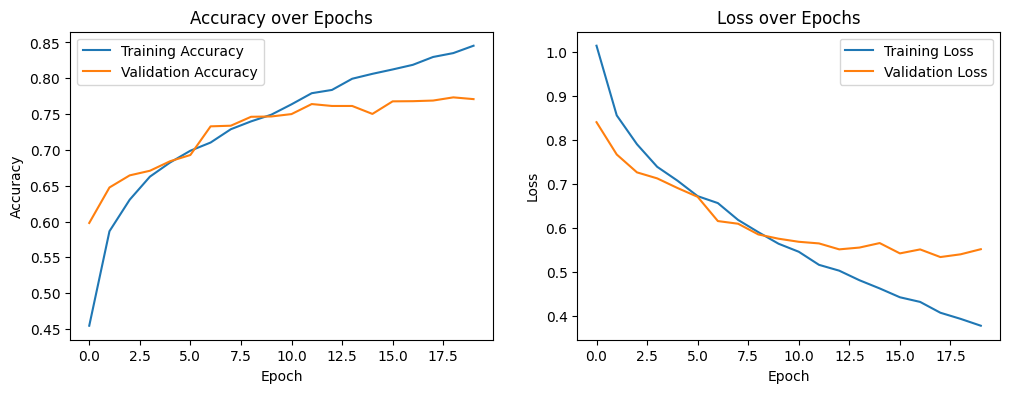

In [19]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [20]:
# 모델 성능 평가
loss, accuracy = model.evaluate(x_test, y_test, verbose=2)
print(f"\n- 테스트 데이터 정확도: {accuracy*100:.2f}%")

94/94 - 1s - 12ms/step - accuracy: 0.7733 - loss: 0.5611

- 테스트 데이터 정확도: 77.33%
